# Highlight->Summarize experiments

In [31]:
import os
import time
import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.qa import QAEvaluator
from src.hs import HSBaseline, HSStructuredHighlighter, HSBERTExtractor
from src.judges import LLMJudgeStructured
from src.utils import openai_client, NOANSWER_PRED
from src.data import load_repliqa, load_bioasq

## Data

Select here the datasets to use (and whether you just want to work on a small sample).

In [3]:
repliqa = load_repliqa(split=3)
bioasq = load_bioasq()

N = 40
repliqa_subsampled = repliqa.select(range(int(N/2)))
repliqa_subsampled = datasets.concatenate_datasets([
    repliqa_subsampled,
    repliqa.filter(lambda example: example["answer"] == NOANSWER_PRED).select(range(int(N/2)))
])
bioasq_subsampled = bioasq.select(range(N))

DATASETS = {
    "repliqa_3": repliqa_subsampled,
    "bioasq": bioasq_subsampled,
}

Loading dataset: repliqa_3
Loading dataset: bioasq


## Config

In [4]:
RESULTS_DIR = "results/{dataset_name}"
TEMPERATURE = 0.2
PIPELINES = [
    {"pipeline": QAEvaluator, "model_name": "gpt-4.1-mini", "temperature": TEMPERATURE},
    {"pipeline": HSBaseline, "model_name": "gpt-4.1-mini", "temperature": TEMPERATURE},
    {"pipeline": HSStructuredHighlighter, "model_name": "gpt-4.1-mini", "temperature": TEMPERATURE},
    # {"pipeline": HSBERTExtractor, "model_name": "gpt-4.1-mini", "temperature": TEMPERATURE},
]
N_PROC = 1
N_TRIALS = 5

## Evaluation

The evaluation is made of two steps: question answering and judgement.
Their results are stored as two separate datasets (`.predicted` and `.judged`).
The dataset `.judged` is what we use in subsequent data analysis,
and it contains all the information that `.predicted` has.
(`.predicted` is mostly used as a cache, to allow regenerating `.judged` data
without having to re-run the inference.)

In [ ]:
inference_datasets = {}

for dataset_name, dataset in DATASETS.items():
    print(f"Running inference for dataset: {dataset_name}")
    results_dir = RESULTS_DIR.format(dataset_name=dataset_name)
    for pipeline in PIPELINES:
        model_name = pipeline["model_name"]
        rag_pipeline = pipeline["pipeline"]
        temperature = pipeline["temperature"]
        run_id = f"{rag_pipeline.__name__}-{model_name}"

        print(f"* Running inference for: {model_name} with {rag_pipeline.__name__} pipeline.")
        ######################
        # Question answering.
        ######################
        if os.path.exists(os.path.join(results_dir, f"{run_id}.predicted")):
            print(f"Loading predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
            prediction_dataset = datasets.load_from_disk(os.path.join(results_dir, f"{run_id}.predicted"))
            if "answer_pred" in prediction_dataset.column_names:
                print(f"Skipping predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
            else:
                raise Exception("This shouldn't happen: missing 'answer_pred' column but dataset exists.")
        else:
            print(f"Generating predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
            pipeline = rag_pipeline(
                model_name=model_name,
                openai_client=openai_client,
                temperature=temperature,
                n_trials=N_TRIALS,
            )
            now = time.time()
            prediction_dataset = dataset.map(
                pipeline,
                desc=f"Generating predictions (Model: {model_name}, Pipeline: {rag_pipeline.__name__})",
                num_proc=N_PROC,
                load_from_cache_file=False,
                )
            elapsed_time = time.time() - now
            print(f"Elapsed time for predictions: {elapsed_time:.2f} seconds. Average: {elapsed_time / len(dataset):.2f} seconds per example.")
            # Store.
            print(f"Storing predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
            prediction_dataset.save_to_disk(os.path.join(results_dir, f"{run_id}.predicted"))

        #######################
        # Judges.
        #######################
        if os.path.exists(os.path.join(results_dir, f"{run_id}.judged")):
            judged_dataset = datasets.load_from_disk(os.path.join(results_dir, f"{run_id}.judged"))
            print(f"Skipping judging for: {model_name} with {rag_pipeline.__name__} pipeline.")
        else:
            judge = LLMJudgeStructured(openai_client=openai_client)
            judged_dataset = prediction_dataset.map(
                judge,
                desc=f"Judging predictions for: {model_name} with {rag_pipeline.__name__} pipeline.",
                num_proc=N_PROC,
                load_from_cache_file=False,
            )
            # Store.
            print(f"Storing judged predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
            judged_dataset.save_to_disk(os.path.join(results_dir, f"{run_id}.judged"))
        
        # Store inference dataset.
        inference_datasets[dataset_name] = inference_datasets.get(dataset_name, {})
        inference_datasets[dataset_name][run_id] = judged_dataset

Running inference for dataset: repliqa_3
* Running inference for: gpt-4.1-mini with QAEvaluator pipeline.
Loading predictions for: gpt-4.1-mini with QAEvaluator pipeline.
Skipping predictions for: gpt-4.1-mini with QAEvaluator pipeline.
Skipping judging for: gpt-4.1-mini with QAEvaluator pipeline.
* Running inference for: gpt-4.1-mini with HSBaseline pipeline.
Loading predictions for: gpt-4.1-mini with HSBaseline pipeline.
Skipping predictions for: gpt-4.1-mini with HSBaseline pipeline.
Skipping judging for: gpt-4.1-mini with HSBaseline pipeline.
* Running inference for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Loading predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Skipping predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Skipping judging for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Running inference for dataset: bioasq
* Running inference for: gpt-4.1-mini with QAEvaluator pipeline.
Loading predictions for: gpt-4.1-mini 

**Store to Excel for manual inspection**

In [10]:
import pandas as pd

select = ["question", "answer", "answer_pred", "model_name", "temperature"]
factors = ["correctness", "faithfulness", "naturalness"]
select += [f"MT-bench-QA_{factor}" for factor in factors]
select += [f"MT-bench-QA_{factor}_explanation" for factor in factors]
try_select = ['summarizer_llm_response', 'summarizer_llm_guessed_question', 'highlighter_extracted', 'highlighter_llm_response', 'highlighter_text_extracts', 'highlighter_fuzzmatch_scores']
to_cat = []

for dataset_name, judged_predictions in inference_datasets.items():
    for model_name, judged_preds in judged_predictions.items():
        try:
            to_cat.append(pd.DataFrame(judged_preds)[select + try_select])
        except KeyError:
            to_cat.append(pd.DataFrame(judged_preds)[select])
        to_cat[-1]["pipeline"] = model_name.split("-")[0]
        if "raw_text_extracts" in judged_preds.column_names:
            to_cat[-1]["raw_text_extracts"] = judged_preds["raw_text_extracts"]
        else:
            to_cat[-1]["raw_text_extracts"] = None

    df = pd.concat(to_cat, ignore_index=True)
    df.to_excel(
        os.path.join(RESULTS_DIR.format(dataset_name=dataset_name), "results.xlsx"),
        index=False,
        engine="openpyxl"
)

#### Data analysis

**Scores on answerable questions**

##### Correct questions (among those that can be answered)

In [13]:
MIN_RATING = 1
MAX_RATING = 5
judge_name = "MT-bench-QA"

ratings = {}

for dataset_name, judged_predictions in inference_datasets.items():
    ratings[dataset_name] = {}
    for model_name in judged_predictions:
        dataset = judged_predictions[model_name].filter(
            lambda example: example["answer"] != NOANSWER_PRED,
            load_from_cache_file=False
        )
        for factor in ["correctness", "faithfulness", "naturalness"]:
            col = f"{judge_name}_{factor}"
            ratings[dataset_name].setdefault(model_name, {})[col] = dataset[col]

Filter: 100%|██████████| 40/40 [00:00<00:00, 8058.61 examples/s]


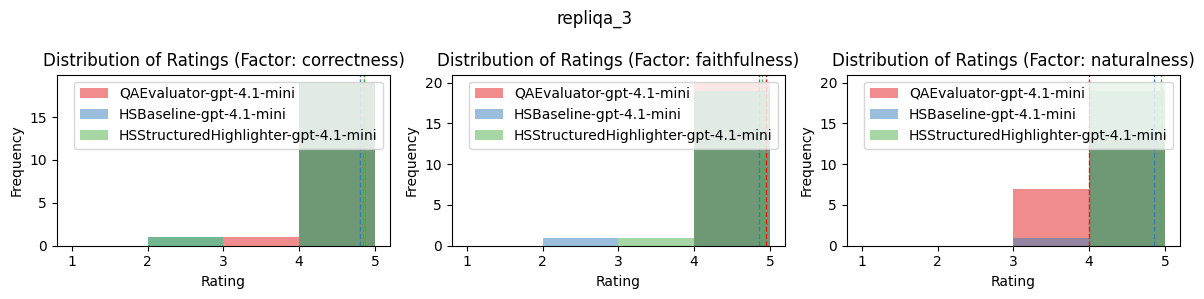

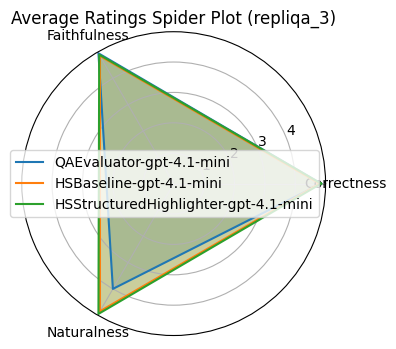

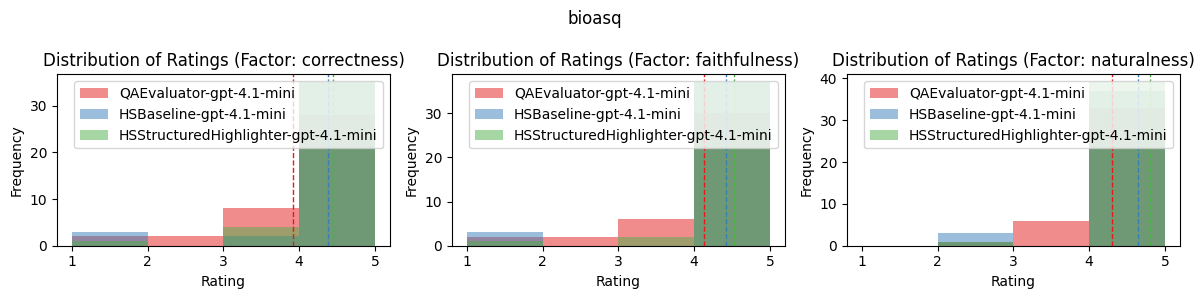

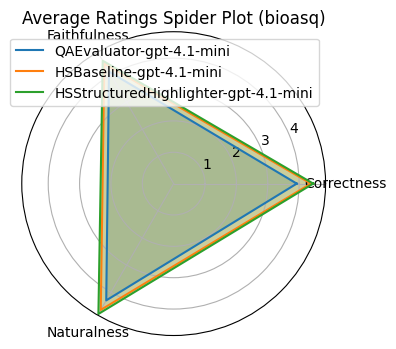

In [24]:
judge_name = "MT-bench-QA"
llms = ["gpt-4.1-mini"]
for dataset_name, dataset_ratings in ratings.items():
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 3))
    for factor, ax in zip(["correctness", "faithfulness", "naturalness"], axes.flatten()):
        #plt.figure(figsize=(4, 3))
        colors = sns.color_palette("Set1", n_colors=len(dataset_ratings))
        for model_name in dataset_ratings:
            model_ratings = dataset_ratings[model_name]
            color = colors.pop(0)
            judge_ratings = model_ratings[f"{judge_name}_{factor}"]
            ax.hist(judge_ratings, alpha=0.5, label=f"{model_name}", color=color, density=False, bins=np.arange(MIN_RATING, MAX_RATING + 1, 1))
            # A vertical line for each model's average rating.
            avg_rating = np.mean(judge_ratings)
            ax.axvline(avg_rating, linestyle='--', linewidth=1, color=color) #label=f"{model_name} Avg"

        ax.set_xlabel("Rating")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Distribution of Ratings (Factor: {factor})")
        # plt.suptitle(dataset_name)
        ax.set_xticks(np.arange(MIN_RATING, MAX_RATING + 1, 1))
        ax.legend()
        plt.suptitle(dataset_name)
        plt.tight_layout()
    
    # A spider plot for each model's average ratings.
    spider_data = {}
    for model_name in dataset_ratings:
        model_ratings = dataset_ratings[model_name]
        avg_ratings = [np.mean(model_ratings[f"{judge_name}_{factor}"]) for factor in ["correctness", "faithfulness", "naturalness"]]
        spider_data[model_name] = avg_ratings
    # Create a spider plot.
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
    num_vars = len(spider_data[next(iter(spider_data))])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    for model_name, avg_ratings in spider_data.items():
        avg_ratings += avg_ratings[:1]  # Complete the loop
        ax.plot(angles, avg_ratings, label=model_name)
        ax.fill(angles, avg_ratings, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(["Correctness", "Faithfulness", "Naturalness"])
    ax.set_title(f"Average Ratings Spider Plot ({dataset_name})")
    plt.legend()
    plt.tight_layout()

#### Unanswerable

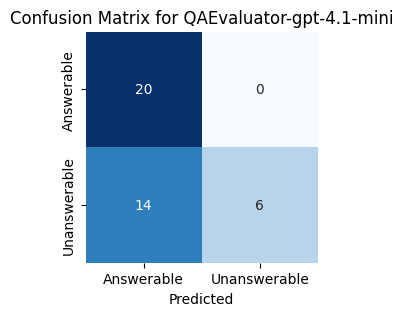

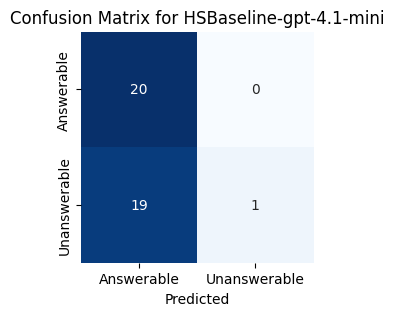

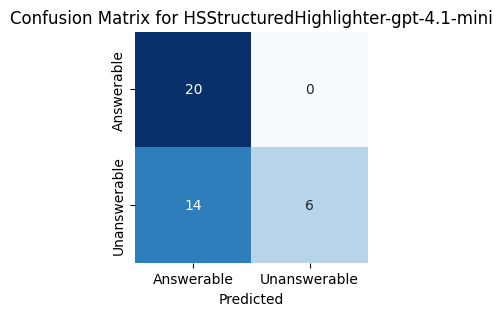

In [32]:
# Confusion matrix for (answer is answerable/unanswerable, answer_pred is answerable/unanswerable)
for model_name in inference_datasets:
    if not "mini" in model_name:
        continue
    answerable = inference_datasets[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED
    )
    unanswerable = inference_datasets[model_name].filter(
        lambda example: example["answer"] == NOANSWER_PRED
    )
    answerable_correct = len(answerable.filter(lambda example: example["answer_pred"] != NOANSWER_PRED))
    unanswerable_correct = len(unanswerable.filter(lambda example: example["answer_pred"] == NOANSWER_PRED))

    # Plot as confusion matrix.
    confusion_matrix = np.array([[answerable_correct, len(answerable) - answerable_correct],
                                  [len(unanswerable) - unanswerable_correct, unanswerable_correct]])
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted") 

#### Recall and K-F1

Referring to https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00667/121196.

In [27]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

def ref_answer_recall(answer, answer_pred):
    """This metric measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    if answer == NOANSWER_PRED:
        raise ValueError("Reference answer is NOANSWER_PRED.")

    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    answer_tokens = set(enc.encode(answer))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = answer_tokens.intersection(answer_pred_tokens)
    recall = len(common_tokens) / len(answer_tokens)
    return recall

def ref_passage_precision(passage, answer_pred):
    """This metric measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.
    """
    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    passage_tokens = set(enc.encode(passage))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = passage_tokens.intersection(answer_pred_tokens)
    precision = len(common_tokens) / len(answer_pred_tokens)
    return precision

Model: QAEvaluator-gpt-4.1-mini
  Ref Answer Recall: 0.6697
  Ref Passage Precision: 0.8101
Model: HSBaseline-gpt-4.1-mini
  Ref Answer Recall: 0.7633
  Ref Passage Precision: 0.7268
Model: HSBaseline-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7327
  Ref Passage Precision: 0.8795
Model: HSStructuredHighlighter-gpt-4.1-mini
  Ref Answer Recall: 0.8202
  Ref Passage Precision: 0.7334
Model: HSStructuredHighlighter-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7909
  Ref Passage Precision: 0.8879
Skipping dataset bioasq for evaluation because it doesn't contain `long_answer`.


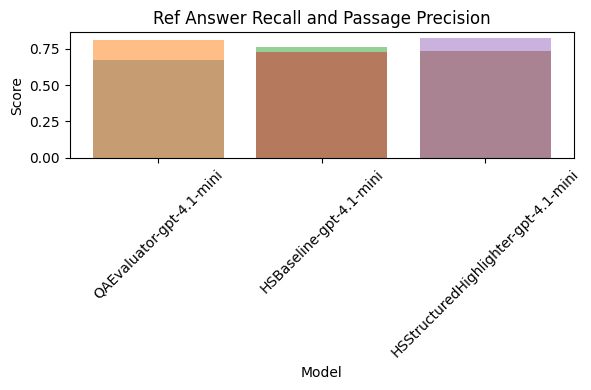

In [30]:
results = {}
for dataset_name, judged_predictions in inference_datasets.items():
    if dataset_name != "repliqa_3":
        print(f"Skipping dataset {dataset_name} for evaluation because it doesn't contain `long_answer`.")
        continue
    for model_name, dataset in judged_predictions.items():
        if not "mini" in model_name:
            continue
        results[model_name] = {
            "ref_answer_recall": [],
            "ref_passage_precision": [],
            "answer_length": [],
            "answer_pred_length": []
        }
        for example in dataset:
            # We skip unanswerable questions.
            if example["answer"] == NOANSWER_PRED:
                continue
            results[model_name]["ref_answer_recall"].append(
                ref_answer_recall(example["answer"], example["answer_pred"])
            )
            results[model_name]["ref_passage_precision"].append(
                ref_passage_precision(example["long_answer"], example["answer_pred"])
            )
        print(f"Model: {model_name}")
        print(f"  Ref Answer Recall: {np.mean(results[model_name]['ref_answer_recall']):.4f}")
        print(f"  Ref Passage Precision: {np.mean(results[model_name]['ref_passage_precision']):.4f}")

        # We also evaluate just the highlighter (i.e., no summarizer) for HS pipelines.
        if "HS" in model_name:
            results[f"{model_name}-highlighter"] = {
                "ref_answer_recall": [],
                "ref_passage_precision": [],
                "answer_length": [],
                "answer_pred_length": []
            }
            for example in dataset:
                if example["answer"] == NOANSWER_PRED:
                    continue
                results[f"{model_name}-highlighter"]["ref_answer_recall"].append(
                    ref_answer_recall(example["answer"], example["highlighter_extracted"])
                )
                results[f"{model_name}-highlighter"]["ref_passage_precision"].append(
                    ref_passage_precision(example["long_answer"], example["highlighter_extracted"])
                )
            print(f"Model: {model_name}-highlighter")
            print(f"  Ref Answer Recall: {np.mean(results[f'{model_name}-highlighter']['ref_answer_recall']):.4f}")
            print(f"  Ref Passage Precision: {np.mean(results[f'{model_name}-highlighter']['ref_passage_precision']):.4f}")

    # Plot the results as a bar chart.
    plt.figure(figsize=(6, 4))
    for model_name, result in results.items():
        if not "mini" in model_name:
            continue
        if "highlighter" in model_name:
            # Skip highlighter-only models for this plot.
            continue
        plt.bar(model_name, np.mean(result["ref_answer_recall"]), label=f"{model_name} Recall", alpha=0.5)
        plt.bar(model_name, np.mean(result["ref_passage_precision"]), label=f"{model_name} Precision", alpha=0.5)
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title("Ref Answer Recall and Passage Precision")
    plt.xticks(rotation=45)
    # plt.legend()
    plt.tight_layout()